In [1]:
.libPaths()

[1] "/sc/arion/projects/CommonMind/tereza/conda/envs/pseudo1_env/lib/R/library"

In [8]:
#--- load libraries
library(scater)
library(SingleCellExperiment)
library(destiny)
library(Seurat)
library(Signac)
library(dplyr)
library(tidyr)
library(ggplot2)

In [17]:
pbmc <- readRDS('./OPCOlig_all_preprocessedv2_cdDNA.rds')
pbmc


An object of class Seurat 
215236 features across 60767 samples within 3 assays 
Active assay: SCT (16196 features, 3000 variable features)
 2 other assays present: RNA, ATAC
 12 dimensional reductions calculated: pca, harmonyBB.pca, umapBB.rnah, lsi, harmonyBB.lsi, umapBB.atach, wnnBB.umap, harmony.dream2BB.pca, umap.dream2BB.rnah, harmony.dream2BB.lsi, umap.dream2BB.atach, wnn.dream2BB.umap

In [95]:
#---- this step is only for multi-modal data!!!!

#---- Diet Seurat object
DefaultAssay(pbmc) <- "RNA"
obj <- DietSeurat(pbmc, counts = TRUE, data = TRUE, scale.data = FALSE,
                         assays="RNA")
obj

#obj <- subset(obj, subset=Cell.type=='Oligodendrocyte')

An object of class Seurat 
17608 features across 60767 samples within 1 assay 
Active assay: RNA (17608 features, 2000 variable features)

In [96]:
#----- subsample seurat object if it's too large to be handled by R
pbmc.subsampled <- obj[, sample(colnames(obj), size =11000, replace=F)]
pbmc.subsampled 


An object of class Seurat 
17608 features across 11000 samples within 1 assay 
Active assay: RNA (17608 features, 2000 variable features)

In [97]:
#--- remove and clean
rm(obj)
gc()

used       (Mb)    gc trigger  (Mb)    max used    (Mb)    
Ncells   13915041   743.2    25760055  1375.8    25760055   1375.8
Vcells 4334300912 33068.1 12829032386 97877.8 13437614414 102520.9

In [98]:
#----- convert age string into integer!

new_str <- gsub('y','',pbmc.subsampled@meta.data$age)
pbmc.subsampled@meta.data$age_int <- strtoi(new_str)

unique(pbmc.subsampled@meta.data$age_int)

[1]  0  4 14 39  6 62 61 20

In [99]:
#-- convert to single cell experiment object

obj.sce <- as.SingleCellExperiment(pbmc.subsampled)
obj.sce

class: SingleCellExperiment 
dim: 17608 11000 
metadata(0):
assays(2): counts logcounts
rownames(17608): OR4F5 OR4F29 ... BPY2C CDY1
rowData names(0):
colnames(11000): hipp_4413_CCTTGCGTCCTAGTCC-1
  DLPFC_6032_GTTGGAGCAGTTTGTG-1 ... DLPFC_6032_AGGTTACTCCGCCTCA-1
  caudate_150663_GCACTTACAGCTCATA-1
colData names(100): orig.ident nCount_RNA ... age_int ident
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):

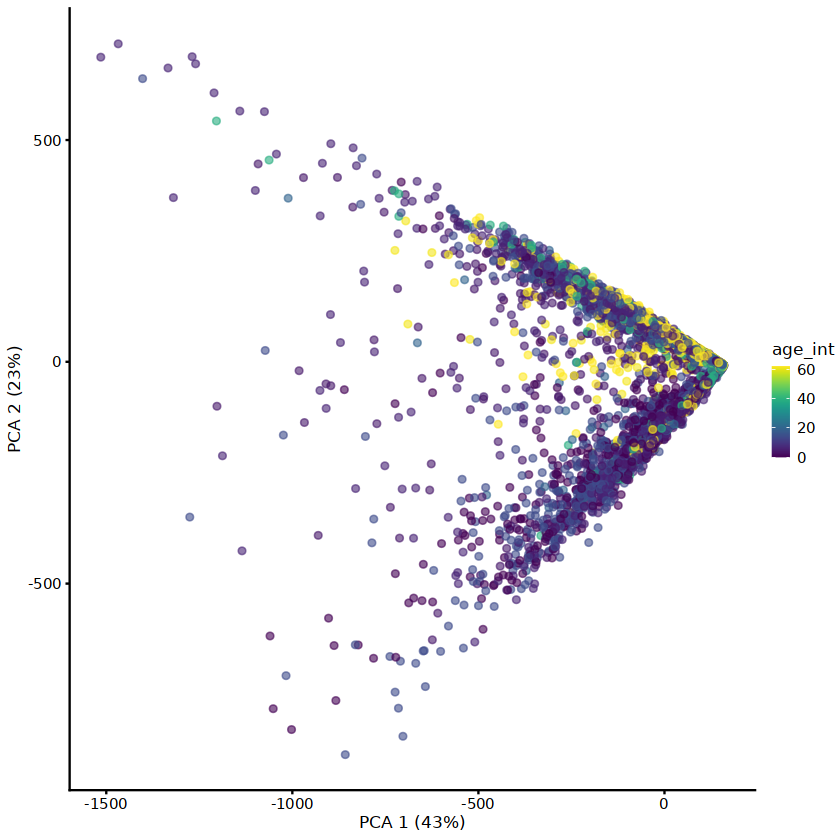

In [24]:
#----- run PCA recution for comparison
obj.sce <- runPCA(obj.sce, ncomponents = 30)
plotReducedDim(obj.sce, dimred="PCA", colour_by="age_int")

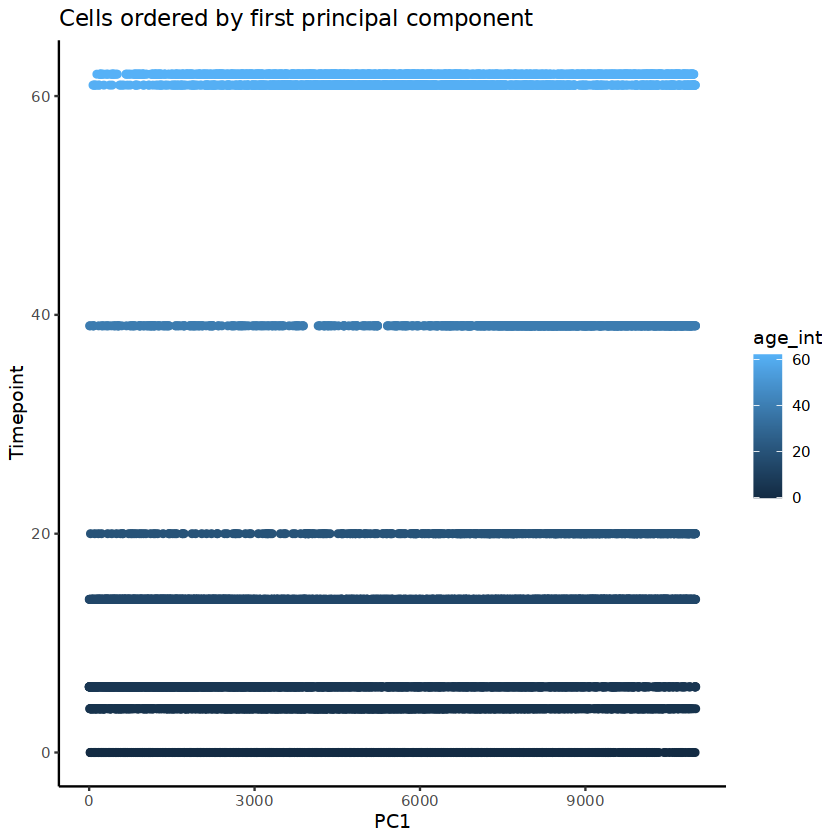

In [25]:
#--- PCA for cells aligned across pseudotime
pca <- reducedDim(obj.sce, type = 'PCA')

obj.sce$pseudotime_PC1 <- rank(pca[,1])
ggplot(as.data.frame(colData(obj.sce)), aes(x = pseudotime_PC1, y = age_int,
                                             colour = age_int)) +
    geom_point() + theme_classic() +
    xlab("PC1") + ylab("Timepoint") +
    ggtitle("Cells ordered by first principal component")

In [28]:
obj.sce

class: SingleCellExperiment 
dim: 17608 11000 
metadata(0):
assays(2): counts logcounts
rownames(17608): OR4F5 OR4F29 ... BPY2C CDY1
rowData names(0):
colnames(11000): caudate_150663_TGTAAAGCACAGACTC-1
  ACC_150672_TACTGACAGCTTACTT-1 ... hipp_6032_GCTCGATCACCATATG-1
  ACC_150672_ATAAGTCGTAAGGTCC-1
colData names(101): orig.ident nCount_RNA ... ident pseudotime_PC1
reducedDimNames(1): PCA
mainExpName: RNA
altExpNames(0):

In [35]:
#--- prepare a counts matrix with labeled rows and columns.
matrix <- as.matrix(assay(obj.sce, i = 'logcounts')) 

Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.4 GiB"


Warning message:
"as(<dsCMatrix>, "dsTMatrix") is deprecated since Matrix 1.5-0; do as(., "TsparseMatrix") instead"


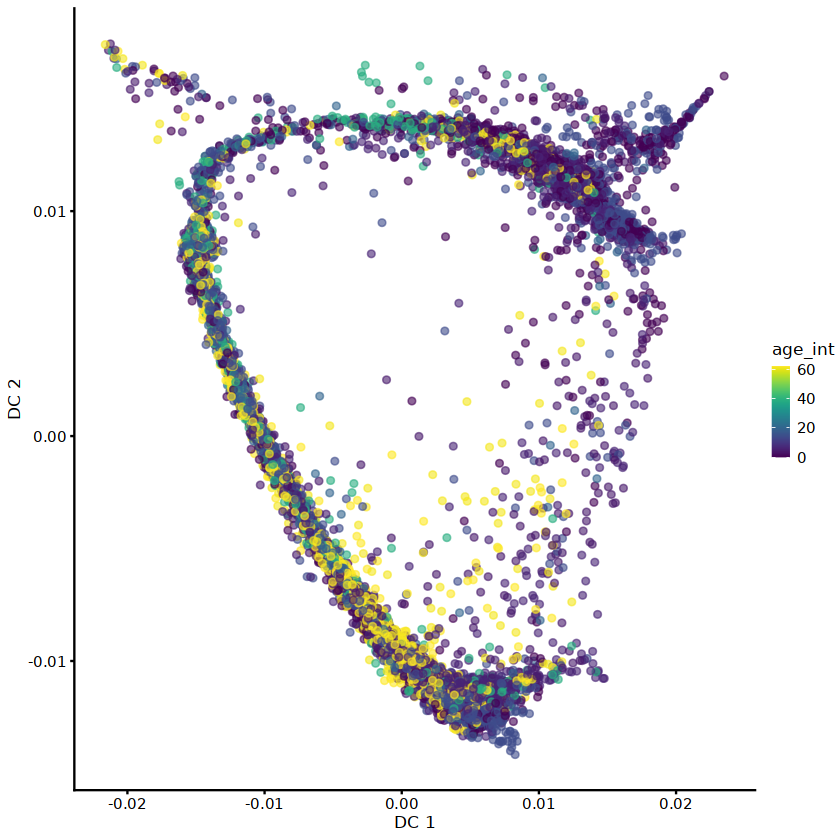

In [36]:
#--- calculate diffusion map
dm <- DiffusionMap(t(matrix), n_pcs = 30) # Make a diffusion map.
reducedDim(obj.sce, type = 'DC') <- dm@eigenvectors
plotReducedDim(obj.sce, dimred="DC", colour_by="age_int")

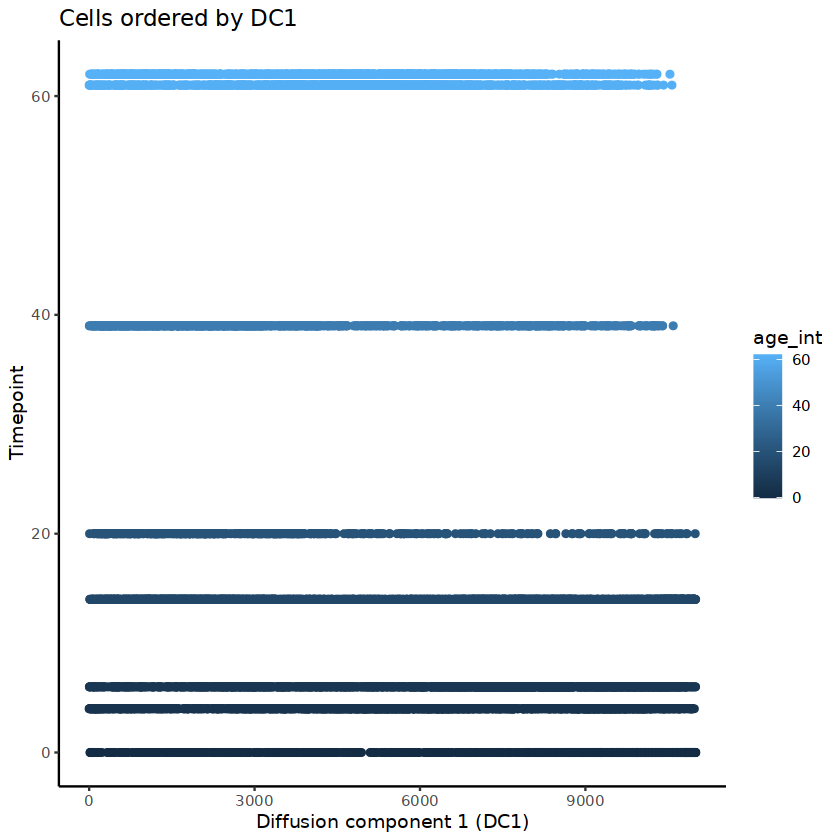

In [38]:
#---  rank cells by their dpt
# plot DC1 component for ordered cells

obj.sce$pseudotime_diffusionmap <- rank(eigenvectors(dm)[,1])   # rank cells by their dpt
ggplot(as.data.frame(colData(obj.sce)),
       aes(x = pseudotime_diffusionmap,
           y = age_int, color = age_int)) + geom_point() + theme_classic() +
    xlab("Diffusion component 1 (DC1)") + ylab("Timepoint") +
    ggtitle("Cells ordered by DC1")

In [42]:
colnames(as.data.frame(colData(obj.sce)))

[1] "orig.ident"                        "nCount_RNA"                       
  [3] "nFeature_RNA"                      "gex_barcode"                      
  [5] "atac_barcode"                      "is_cell"                          
  [7] "excluded_reason"                   "gex_raw_reads"                    
  [9] "gex_mapped_reads"                  "gex_conf_intergenic_reads"        
 [11] "gex_conf_exonic_reads"             "gex_conf_intronic_reads"          
 [13] "gex_conf_exonic_unique_reads"      "gex_conf_exonic_antisense_reads"  
 [15] "gex_conf_exonic_dup_reads"         "gex_exonic_umis"                  
 [17] "gex_conf_intronic_unique_reads"    "gex_conf_intronic_antisense_reads"
 [19] "gex_conf_intronic_dup_reads"       "gex_intronic_umis"                
 [21] "gex_conf_txomic_unique_reads"      "gex_umis_count"                   
 [23] "gex_genes_count"                   "atac_raw_reads"                   
 [25] "atac_unmapped_reads"               "atac_lowmapq"                     
 [27] "atac_dup_reads"                    "atac_chimeric_reads"              
 [29] "atac_mitochondrial_reads"          "atac_fragments"                   
 [31] "atac_TSS_fragments"                "atac_peak_region_fragments"       
 [33] "atac_peak_region_cutsites"         "percent.mt"                       
 [35] "nCount_ATAC"                       "nFeature_ATAC"                    
 [37] "sex"                               "age"                              
 [39] "mitoRatio"                         "percent.ribo"                     
 [41] "riboRatio"                         "percent.hb"                       
 [43] "log10GenesPerUMI"                  "nucleosome_signal"                
 [45] "nucleosome_percentile"             "TSS.enrichment"                   
 [47] "TSS.percentile"                    "pct_reads_in_peaks"               
 [49] "blacklist_fraction"                "brain"                            
 [51] "brain.bank"                        "nCount_SCT"                       
 [53] "nFeature_SCT"                      "SCT_snn_res.0.2"                  
 [55] "seurat_clusters"                   "ATAC_snn_res.0.2"                 
 [57] "SCT.weight"                        "ATAC.weight"                      
 [59] "wsnn_res.0.2"                      "RNA_snn_res.0.2"                  
 [61] "pANN_0.25_0.09_1648"               "DF.classifications_0.25_0.09_1648"
 [63] "pANN_0.25_0.09_1940"               "DF.classifications_0.25_0.09_1940"
 [65] "pANN_0.25_0.09_2285"               "DF.classifications_0.25_0.09_2285"
 [67] "pANN_0.25_0.09_1241"               "DF.classifications_0.25_0.09_1241"
 [69] "SCT_snn_res.0.4"                   "ATAC_snn_res.0.4"                 
 [71] "wsnn_res.0.4"                      "m1c_labels_subclass"              
 [73] "age.group"                         "seurat_clusters_origBB"           
 [75] "m1c_labels_subclass_origBB"        "anno_clus"                        
 [77] "anno_clus_origBB"                  "anno_clus_origBB2"                
 [79] "SCT.dream2BB.weight"               "ATAC.dream2BB.weight"             
 [81] "seurat_clusters_dream.origBB"      "seurat_clusters_dreamorigBB"      
 [83] "m1c_labels_subclass.dreamBB"       "anno_clus_dreamBB"                
 [85] "anno_clus_dreamorigBB"             "OPC_progenitor1"                  
 [87] "OPC_precursor1"                    "Oligo_precursor1"                 
 [89] "preOligo1"                         "immOligo1"                        
 [91] "matOligo_non1"                     "matOligo_mye1"                    
 [93] "TypeI_opc1"                        "TypeII_opc1"                      
 [95] "TypeI_Olig1"                       "TypeII_Olig1"                     
 [97] "anno_clus_dreamorigBB_bioarx"      "anno_clus_dreamorigBB_v2"         
 [99] "age_int"                           "ident"                            
[101] "pseudotime_PC1"                    "pseudotime_diffusionmap"

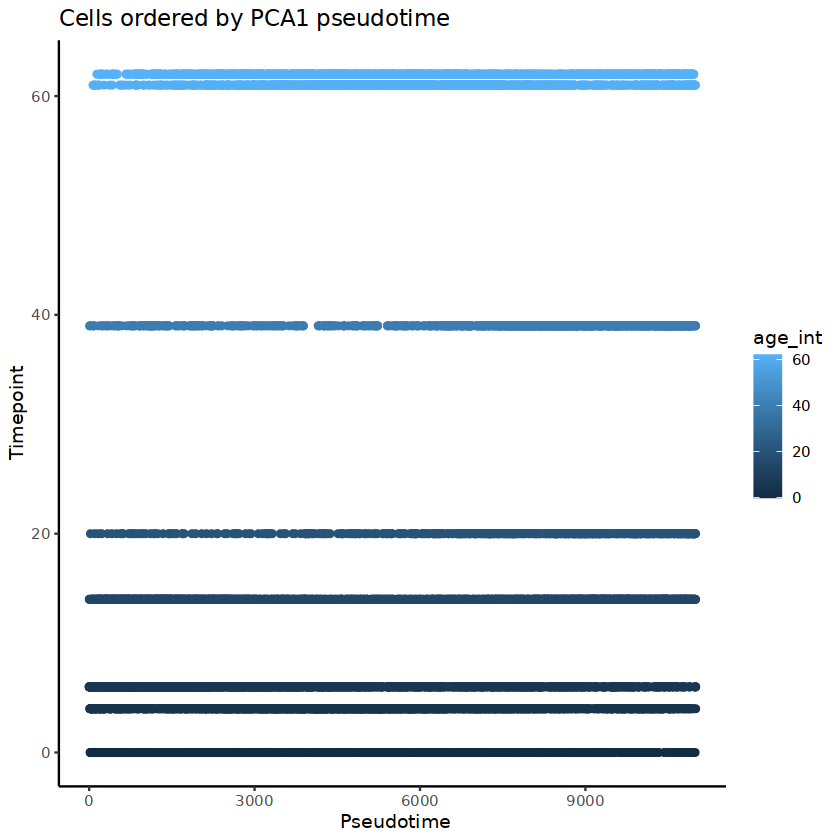

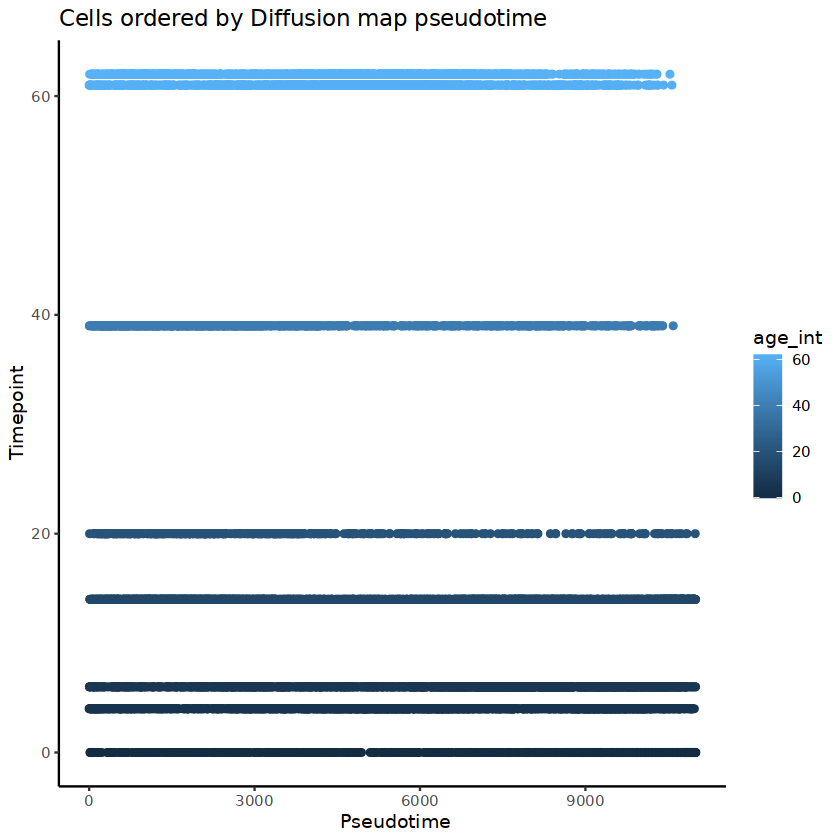

In [78]:
ggplot(as.data.frame(colData(obj.sce)),
       aes(x = pseudotime_PC1,
           y = age_int, color = age_int)) + geom_point() + theme_classic() +
    xlab(" Pseudotime") + ylab("Timepoint") +
    ggtitle("Cells ordered by PCA1 pseudotime")

ggplot(as.data.frame(colData(obj.sce)),
       aes(x = pseudotime_diffusionmap,
           y = age_int, color = age_int)) + geom_point() + theme_classic() +
    xlab(" Pseudotime") + ylab("Timepoint") +
    ggtitle("Cells ordered by Diffusion map pseudotime")

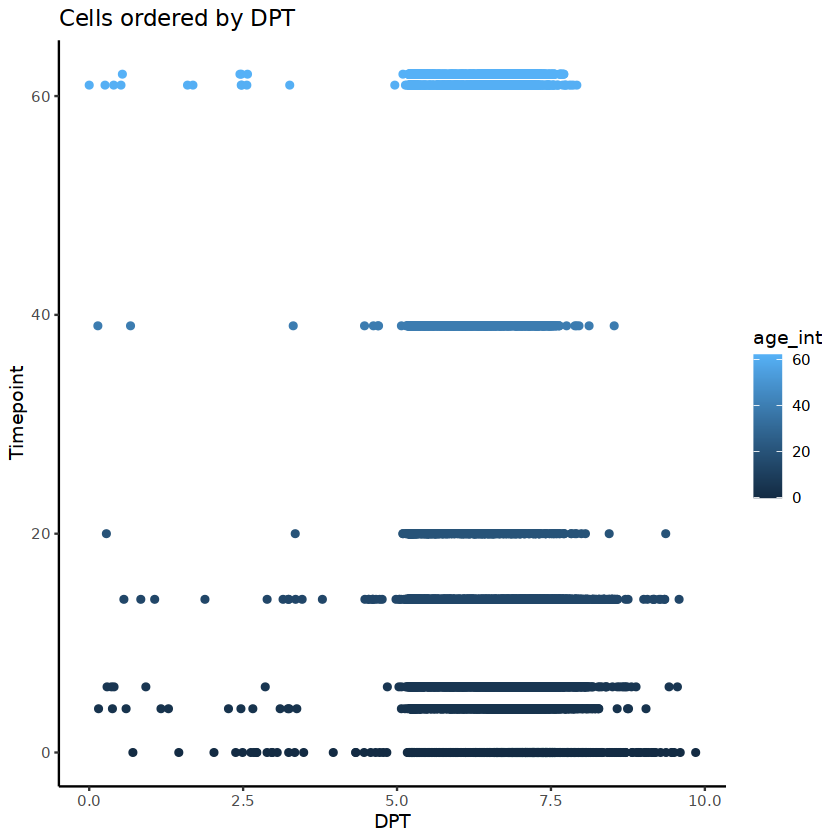

In [45]:
#----- ! order cells based on diffusion pseudotime DPT and observe separation

index <- 1:length(obj.sce$pseudotime_diffusionmap)
dpt <- DPT(dm, tips = index[obj.sce$pseudotime_diffusionmap == 1])
obj.sce$dpt <- dpt$dpt

ggplot(as.data.frame(colData(obj.sce)),
       aes(x = dpt,
           y = age_int, color = age_int)) + geom_point() + theme_classic() +
    xlab("DPT") + ylab("Timepoint") +
    ggtitle("Cells ordered by DPT")

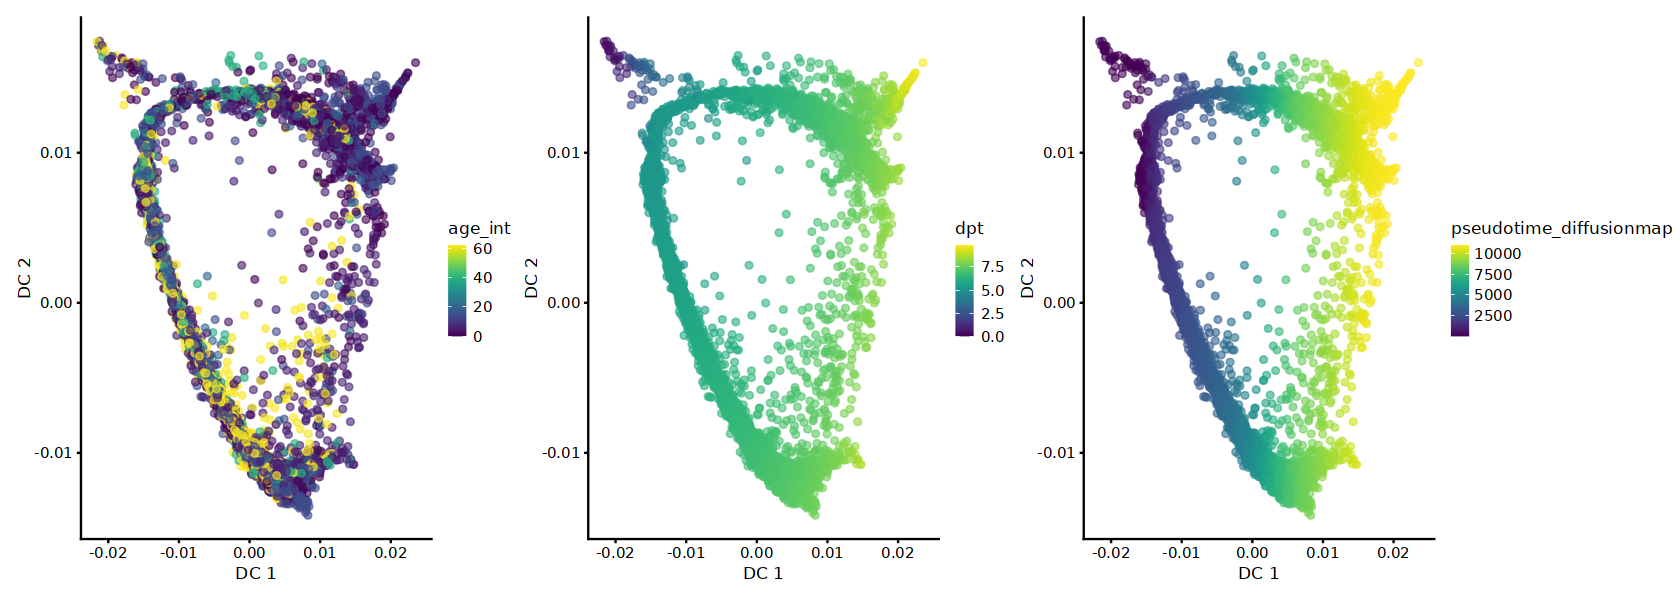

In [81]:
library(patchwork)

#--- plot DC maps and colour based on selected property
options(repr.plot.width=14, repr.plot.height=5)

p1 <- plotReducedDim(obj.sce, dimred="DC", colour_by="age_int")
p2 <- plotReducedDim(obj.sce, dimred="DC", colour_by="dpt")
p3 <-plotReducedDim(obj.sce, dimred="DC", colour_by="pseudotime_diffusionmap")
p1 + p2 + p3 + plot_layout(nrow=1)

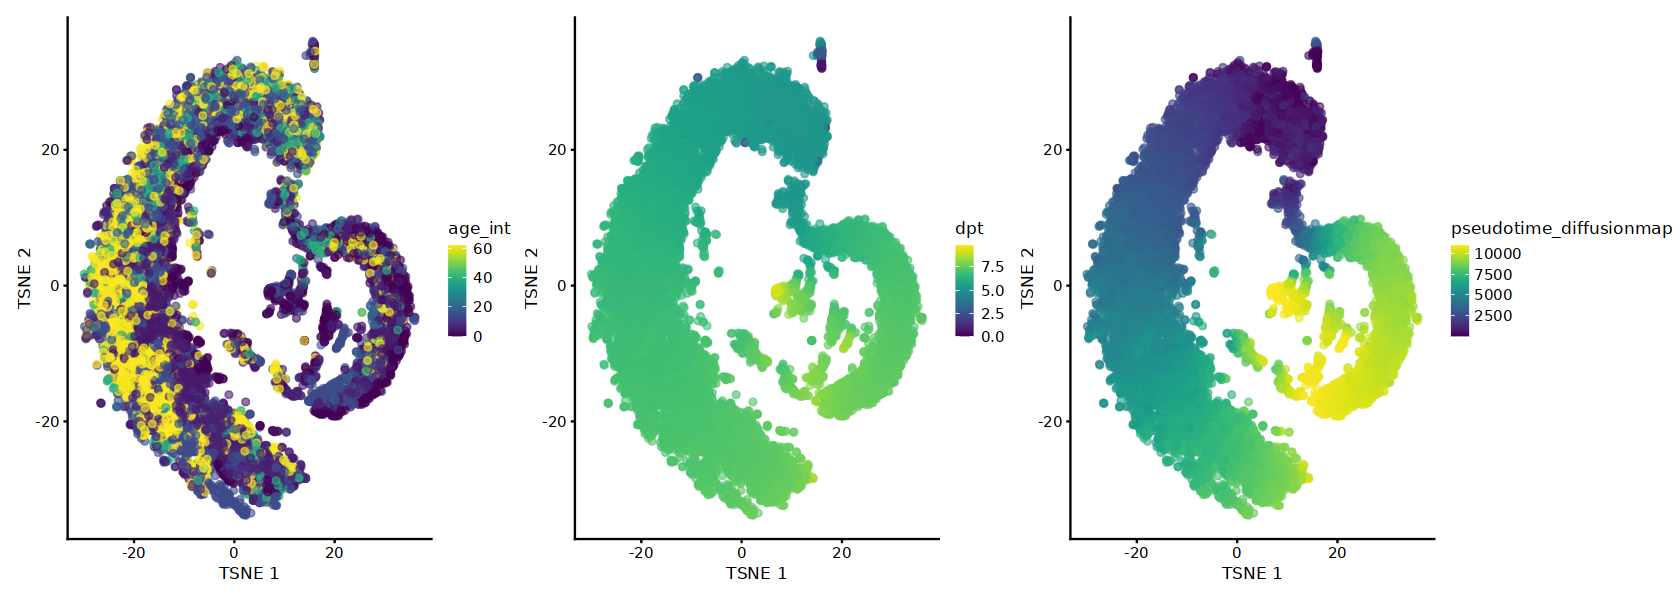

In [82]:
#--- plot tSNE and colour based on selected property

set.seed(42)
obj.sce <- runTSNE(obj.sce, dimred='PCA')
p1 <- plotReducedDim(obj.sce, dimred="TSNE", colour_by="age_int")
p2 <- plotReducedDim(obj.sce, dimred="TSNE", colour_by="dpt")
p3 <-plotReducedDim(obj.sce, dimred="TSNE", colour_by="pseudotime_diffusionmap")
p1 + p2 + p3 + plot_layout(nrow=1)

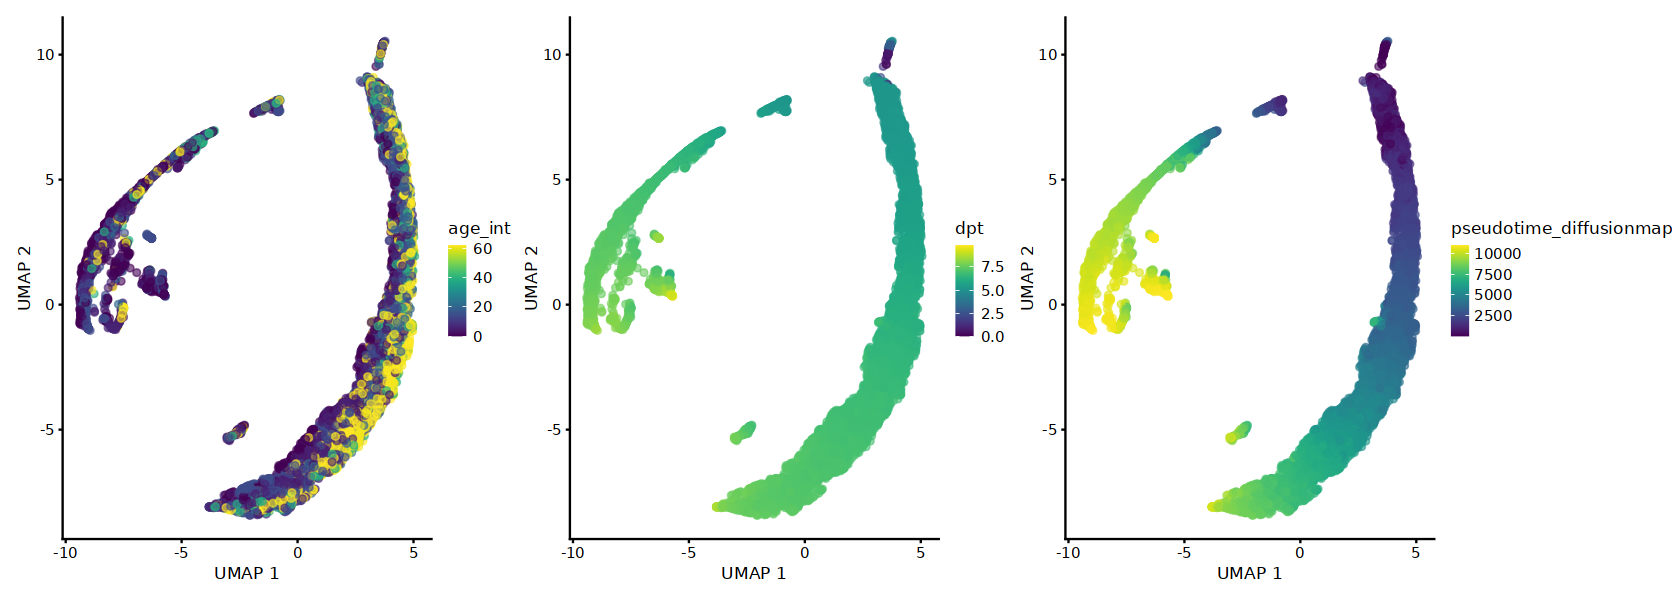

In [84]:
#--- plot UMAPS maps and colour based on selected property

set.seed(42)
obj.sce <- runUMAP(obj.sce, dimred='PCA')
p1 <- plotReducedDim(obj.sce, dimred="UMAP", colour_by="age_int")
p2 <- plotReducedDim(obj.sce, dimred="UMAP", colour_by="dpt")
p3 <-plotReducedDim(obj.sce, dimred="UMAP", colour_by="pseudotime_diffusionmap")
p1 + p2 + p3 + plot_layout(nrow=1)

In [55]:
#--- load libraries for further downstream
library(AnnotationDbi)
library(org.Hs.eg.db)
library(EnsDb.Hsapiens.v86)


In [57]:
#- prepare logcounts as matrix and convert gene names

matrix <- as.matrix(assay(obj.sce, i = 'logcounts'))
Ensembl_id <- rownames(matrix)
head(Ensembl_id)

Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.4 GiB"


[1] "OR4F5"  "OR4F29" "OR4F16" "SAMD11" "NOC2L"  "KLHL17"

In [52]:
#--- most of the time, our data are already prepared so the step below is not needed:


#gene_ids <- ensembldb::select(EnsDb.Hsapiens.v86, keys = Ensembl_id, keytype = 'GENEID', columns = 'SYMBOL')
#rownames(matrix) <- Ensembl_id
#matrix <- matrix[gene_ids$GENEID,]
#rownames(matrix) <- gene_ids$SYMBOL
#head(rownames(matrix))

NULL

In [58]:
head(matrix)

caudate_150663_TGTAAAGCACAGACTC-1 ACC_150672_TACTGACAGCTTACTT-1
OR4F5  0                                 0                            
OR4F29 0                                 0                            
OR4F16 0                                 0                            
SAMD11 0                                 0                            
NOC2L  0                                 1                            
KLHL17 0                                 0                            
       caudate_4422_CCTAAGCCACGAATTT-1 caudate_150663_CTGTTCATCATCCTAT-1
OR4F5  0                               0                                
OR4F29 0                               0                                
OR4F16 0                               0                                
SAMD11 0                               0                                
NOC2L  0                               0                                
KLHL17 0                               0                                
       DLPFC_150666_CAATGAACAGGAAGCC-1 hipp_5936_GGCCATCAGGAGCATA-1
OR4F5  0                               0                           
OR4F29 0                               0                           
OR4F16 0                               0                           
SAMD11 0                               0                           
NOC2L  0                               0                           
KLHL17 0                               0                           
       ACC_6007_GGTACAAAGTTTAACG-1 ACC_6032_CTTATGTTCATGGTGT-1
OR4F5  0                           0                          
OR4F29 0                           0                          
OR4F16 0                           0                          
SAMD11 0                           0                          
NOC2L  0                           0                          
KLHL17 0                           0                          
       hipp_6032_GATGGACAGGCGCTTA-1 hipp_6007_GTCATGCCAATTAGGA-1 <U+22EF>  
OR4F5  0                            0                            <U+22EF>
OR4F29 0                            0                            <U+22EF>
OR4F16 0                            0                            <U+22EF>
SAMD11 0                            0                            <U+22EF>
NOC2L  0                            0                            <U+22EF>
KLHL17 0                            0                            <U+22EF>
       caudate_150663_CATTGTAAGGAACCGG-1 DLPFC_150666_AGTTGCAGTACTGAAT-1
OR4F5  0                                 0                              
OR4F29 0                                 0                              
OR4F16 0                                 0                              
SAMD11 0                                 0                              
NOC2L  0                                 0                              
KLHL17 0                                 0                              
       ACC_6007_AGAACCGCAGGTCCTG-1 ACC_150672_CCATAAATCGCTATAA-1
OR4F5  0                           0                            
OR4F29 0                           0                            
OR4F16 0                           0                            
SAMD11 0                           0                            
NOC2L  0                           0                            
KLHL17 0                           0                            
       caudate_150663_GAAGGCTAGGCTAATC-1 caudate_150673_TTGCAACAGAACAAGT-1
OR4F5  0                                 0                                
OR4F29 0                                 0                                
OR4F16 0                                 0                                
SAMD11 0                                 0                                
NOC2L  0                                 0                                
KLHL17 0                                 0                                
       caudate_5977_CTACCTCAGAGCCGCT-1 DLPFC_150666_AGACAATAGGCAAGTA-1


In [64]:
#----select several genes to inspect their gene expression progression in pseudotime


require(tidyr)
gene <- c('SOX10', 'ID1', 'OLIG1', 'MYOG') #You can modify this list to whichever genes you want
expr_matrix <- as.data.frame(t(rbind(matrix[gene,, drop = FALSE],
                    dpt = obj.sce$dpt, age_int = as.character(obj.sce$age_int),
                                     Pseudotime = obj.sce$pseudotime_diffusionmap)))

df <- pivot_longer(expr_matrix, gene, names_to = 'feature', values_to = 'expr')

In [61]:
colnames(df)

[1] "dpt"        "age_int"    "Pseudotime" "feature"    "expr"

In [65]:
#---- add gene expression; dpt and pseudotime along with selected timepoints to data.frame

df$expr <- as.numeric(as.character(df$expr)) #Some of the columns changed to characters after `pivot_longer` for some reason.
df$dpt <- as.numeric(as.character(df$dpt))
df$Pseudotime <- as.numeric(as.character(df$Pseudotime))
df$Time <- as.numeric(as.character(df$age_int)) #Generated a separate column for plotting purposes.

Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Removed 35805 rows containing non-finite values (`stat_summary()`)."
`geom_line()`: Each group consists of only one observation.
i Do you need to adjust the group aesthetic?


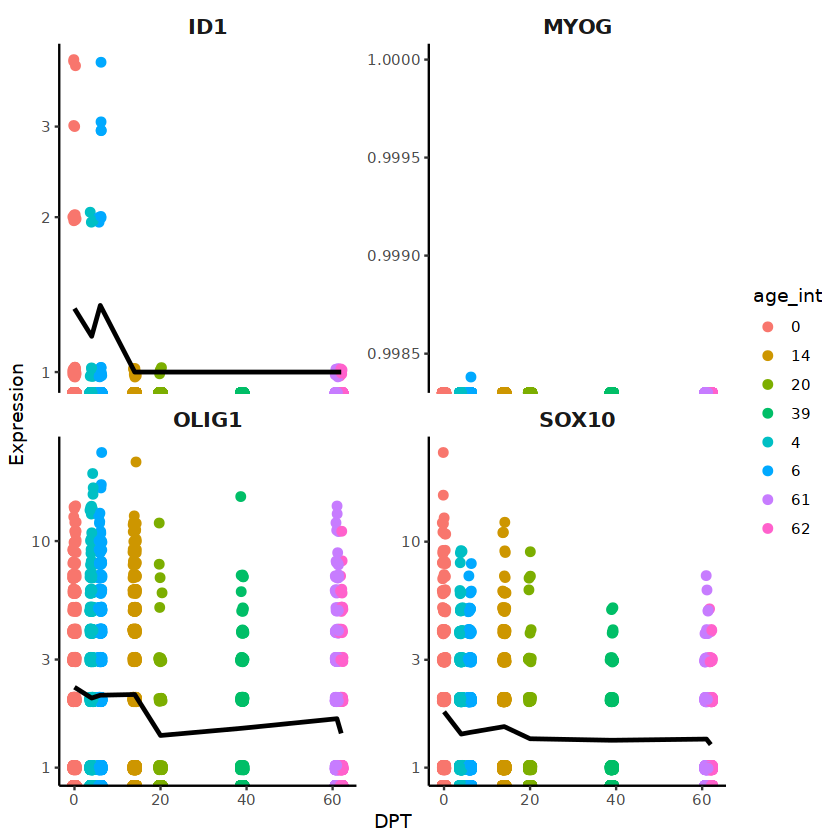

In [66]:
#------ plot gene expression progression along DPT

require(ggplot2)
p <- ggplot(df, mapping = aes(x=Time, y=expr, color=age_int)) + 
geom_jitter(size=2) + theme_classic() + xlab('DPT') + ylab('Expression') + 
theme(plot.title = element_text(size=16, hjust =  0.5, face = 'bold'),
      strip.text = element_text(size=12, face = 'bold'),strip.background = element_rect(size = 0)) +
guides(color = guide_legend(override.aes = list(linetype = 'blank'))) +
scale_y_log10() + 
facet_wrap(~feature,scales = "free_y")

p + stat_summary(fun.y=mean, colour="black", geom="line", size = 1)

Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
Warning message:
"Removed 35805 rows containing non-finite values (`stat_smooth()`)."


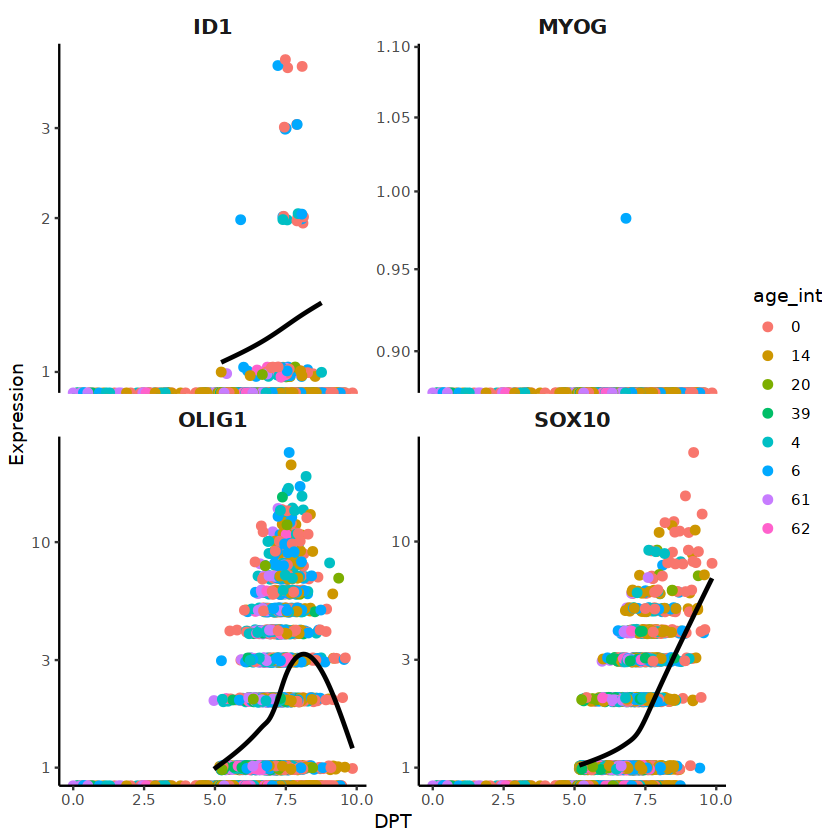

In [67]:
#------ plot gene expression progression along DPT


p <- ggplot(df, mapping = aes(x=dpt, y=expr, color=age_int)) + 
geom_jitter(size=2) + theme_classic() + xlab('DPT') + 
ylab('Expression') +
theme(plot.title = element_text(size=16, hjust =  0.5, face = 'bold'), 
      strip.text = element_text(size=12, face = 'bold'),
      strip.background = element_rect(size = 0)) + 
guides(color = guide_legend(override.aes = list(linetype = 'blank'))) +
scale_y_log10() + 
facet_wrap(~feature,scales = "free_y")
p + geom_smooth(aes(color = expr), method = 'gam', se=F, color = 'black')

Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
Warning message:
"Removed 35805 rows containing non-finite values (`stat_smooth()`)."


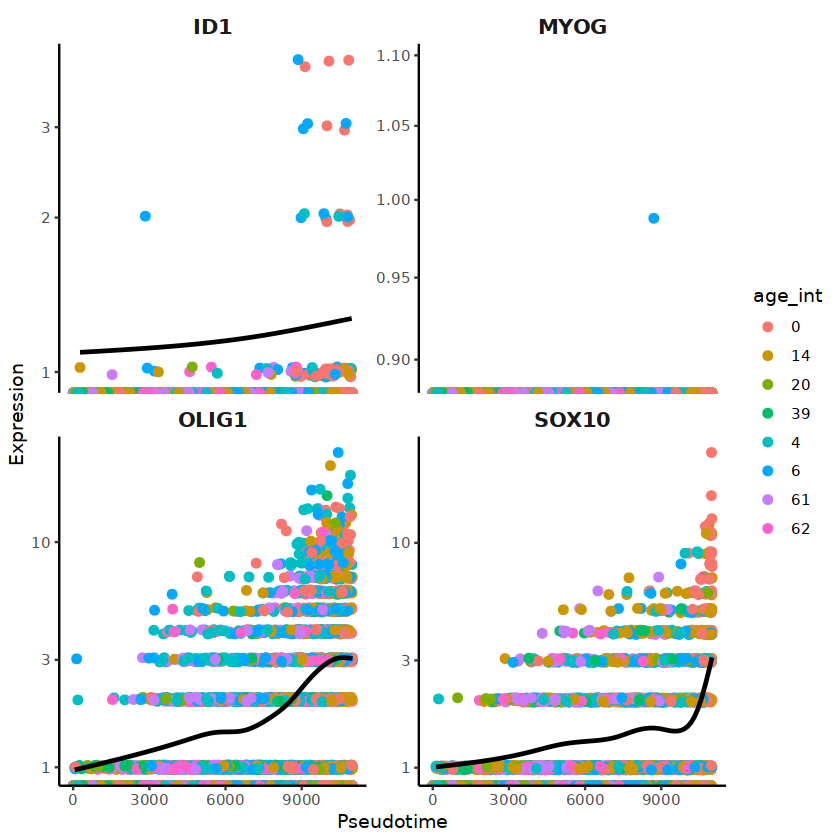

In [68]:
p <- ggplot(df, mapping = aes(x=Pseudotime, y=expr, color=age_int)) + 
geom_jitter(size=2) +
theme_classic() +
xlab('Pseudotime') + 
ylab('Expression') + 
theme(plot.title = element_text(size=16, hjust =  0.5, face = 'bold'),
      strip.text = element_text(size=12, face = 'bold'),
      strip.background = element_rect(size = 0)) + 
guides(color = guide_legend(override.aes = list(linetype = 'blank'))) +
scale_y_log10() +
facet_wrap(~feature,scales = "free_y")
p + geom_smooth(aes(color = expr), method = 'gam', se=F, color = 'black')

In [69]:
#----- prepare for simple statistical modelling
require(gam)

Loading required package: gam

Loading required package: splines

Loading required package: foreach

Loaded gam 1.22-1




In [75]:
#-- -observe gex progression of top selected genes
t <- obj.sce$dpt
var1K <- names(sort(apply(matrix, 1, var),decreasing = TRUE))[1:100] #We select the top variable genes to speed up the calculations. You are more than welcome to use all genes.
matrix <- matrix[var1K, ]

# fit a GAM using a spline
gam.pval <- apply(matrix,1,function(z){
    d <- data.frame(z=z, t=t)
    suppressWarnings({
      tmp <- suppressWarnings(gam(z ~ s(t), data=d))
    })
    p <- summary(tmp)[4][[1]][1,5]
    p
})

topgenes <- sort(gam.pval, decreasing = FALSE)[1:16] #selecting top 16 genes that are temporally expressed
topgenes <- topgenes[topgenes<0.05] %>% names() #filter for p < 0.05

expr_matrix <- as.data.frame(t(rbind(matrix[topgenes,, drop = FALSE],
                                     dpt = obj.sce$dpt, age_int = as.character(obj.sce$age_int))))

df <- pivot_longer(expr_matrix, topgenes, names_to = 'feature', values_to = 'expr')

In [76]:
head(df)

dpt             age_int feature  expr
1 5.9377494459813 62      PCDH9    34  
2 5.9377494459813 62      CADM2    0   
3 5.9377494459813 62      FRMD4A   0   
4 5.9377494459813 62      IL1RAPL1 3   
5 5.9377494459813 62      LSAMP    3   
6 5.9377494459813 62      NRXN1    0

Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
Warning message:
"Removed 49806 rows containing non-finite values (`stat_smooth()`)."


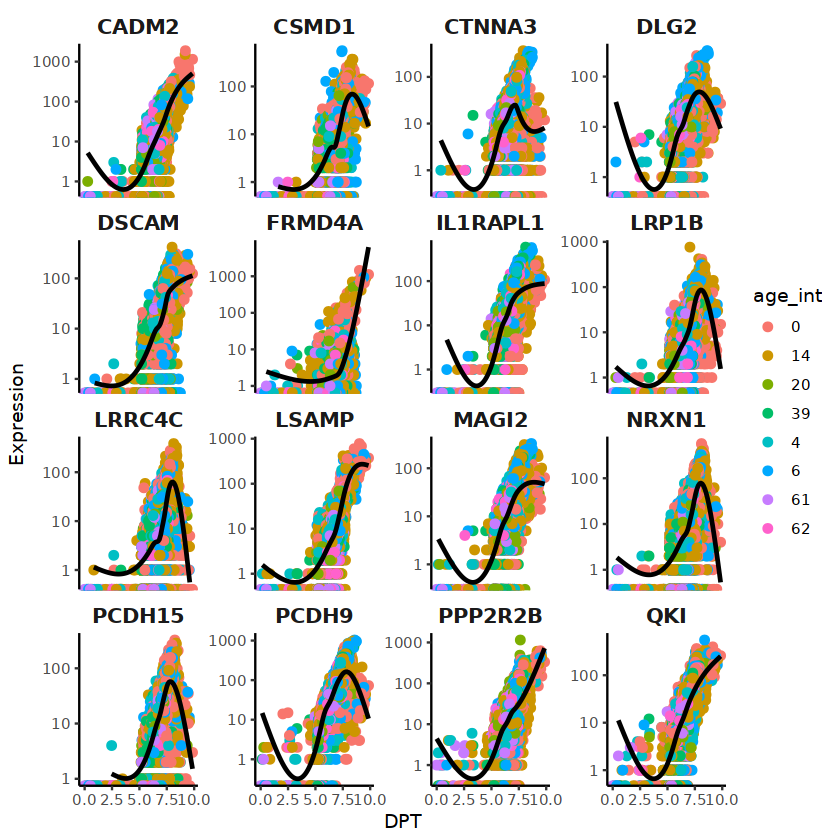

In [77]:
df$expr <- as.numeric(as.character(df$expr)) #Some of the columns changed to characters after `pivot_longer` for some reason.
df$dpt <- as.numeric(as.character(df$dpt))

p <- ggplot(df, mapping = aes(x=dpt, y=expr, color=age_int)) +
geom_jitter(size=2) + 
theme_classic() + 
xlab('DPT') +
ylab('Expression') + 
theme(plot.title = element_text(size=16, hjust =  0.5, face = 'bold'),
      strip.text = element_text(size=12, face = 'bold'),
      strip.background = element_rect(size = 0)) + 
guides(color = guide_legend(override.aes = list(linetype = 'blank'))) +
scale_y_log10() + facet_wrap(~feature,scales = "free_y")
p + geom_smooth(aes(color = expr), method = 'gam', se=F, color = 'black')

In [ ]:
#============== repeat the above analysis with different parameters for dim reduction

In [ ]:
#------- nPCA = 20

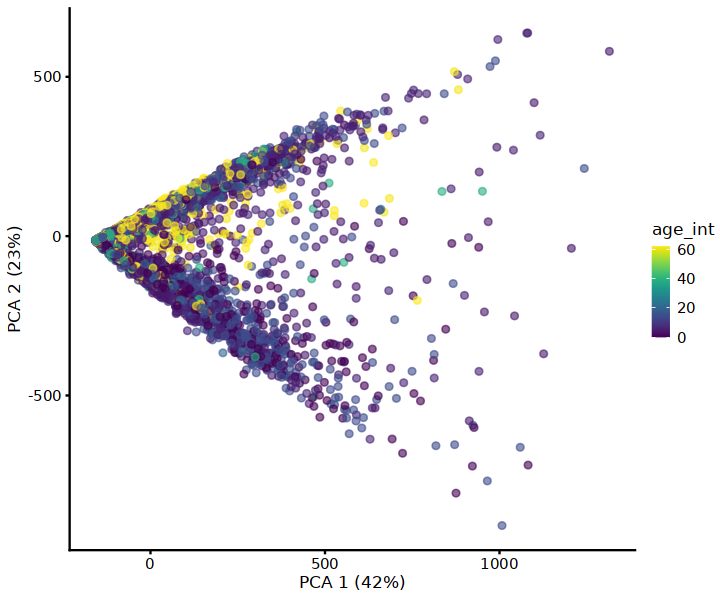

In [100]:
obj.sce <- runPCA(obj.sce, ncomponents = 20)

options(repr.plot.width=6, repr.plot.height=5)
plotReducedDim(obj.sce, dimred="PCA", colour_by="age_int")



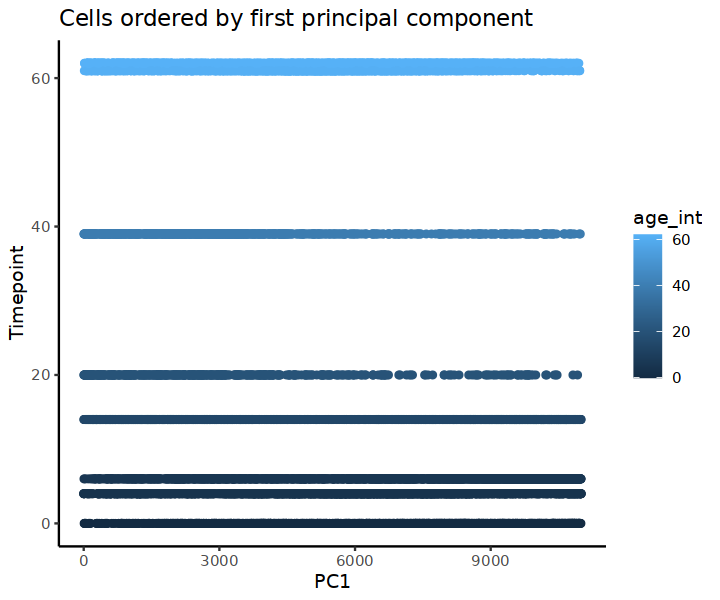

In [101]:
pca <- reducedDim(obj.sce, type = 'PCA')

obj.sce$pseudotime_PC1 <- rank(pca[,1])

options(repr.plot.width=6, repr.plot.height=5)
ggplot(as.data.frame(colData(obj.sce)), aes(x = pseudotime_PC1, y = age_int,
                                             colour = age_int)) +
    geom_point() + theme_classic() +
    xlab("PC1") + ylab("Timepoint") +
    ggtitle("Cells ordered by first principal component")

Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.4 GiB"


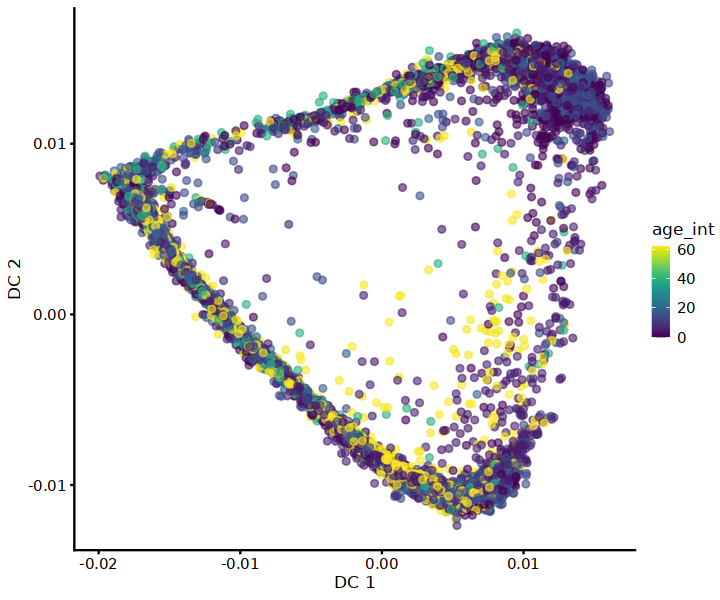

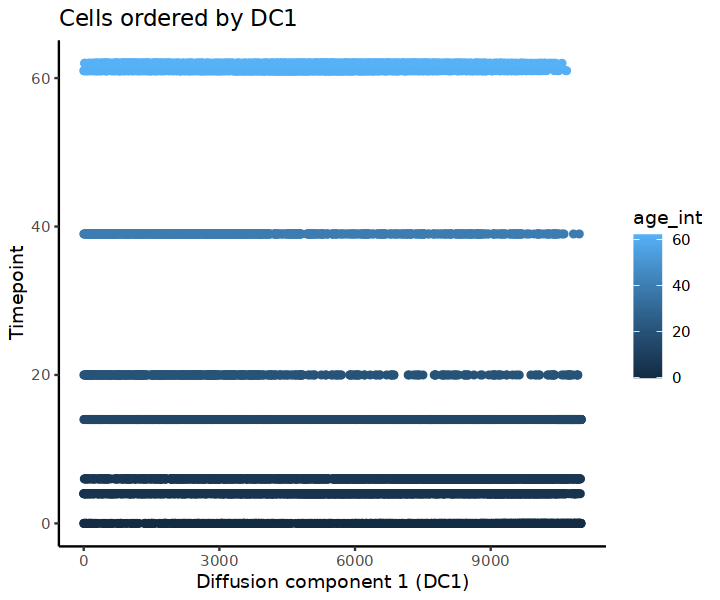

In [102]:
matrix <- as.matrix(assay(obj.sce, i = 'logcounts')) #  Prepare a counts matrix with labeled rows and columns.
dm <- DiffusionMap(t(matrix), n_pcs = 15) # Make a diffusion map.
reducedDim(obj.sce, type = 'DC') <- dm@eigenvectors
plotReducedDim(obj.sce, dimred="DC", colour_by="age_int")

obj.sce$pseudotime_diffusionmap <- rank(eigenvectors(dm)[,1])   # rank cells by their dpt

options(repr.plot.width=6, repr.plot.height=5)
ggplot(as.data.frame(colData(obj.sce)),
       aes(x = pseudotime_diffusionmap,
           y = age_int, color = age_int)) + geom_point() + theme_classic() +
    xlab("Diffusion component 1 (DC1)") + ylab("Timepoint") +
    ggtitle("Cells ordered by DC1")

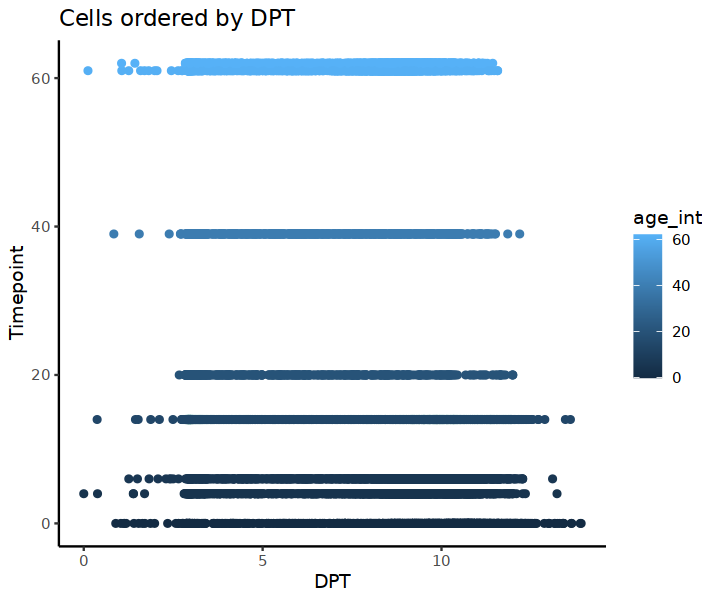

In [103]:
index <- 1:length(obj.sce$pseudotime_diffusionmap)
dpt <- DPT(dm, tips = index[obj.sce$pseudotime_diffusionmap == 1])
obj.sce$dpt <- dpt$dpt

options(repr.plot.width=6, repr.plot.height=5)
ggplot(as.data.frame(colData(obj.sce)),
       aes(x = dpt,
           y = age_int, color = age_int)) + geom_point() + theme_classic() +
    xlab("DPT") + ylab("Timepoint") +
    ggtitle("Cells ordered by DPT")

In [113]:
colnames(as.data.frame(colData(obj.sce)))

[1] "orig.ident"                        "nCount_RNA"                       
  [3] "nFeature_RNA"                      "gex_barcode"                      
  [5] "atac_barcode"                      "is_cell"                          
  [7] "excluded_reason"                   "gex_raw_reads"                    
  [9] "gex_mapped_reads"                  "gex_conf_intergenic_reads"        
 [11] "gex_conf_exonic_reads"             "gex_conf_intronic_reads"          
 [13] "gex_conf_exonic_unique_reads"      "gex_conf_exonic_antisense_reads"  
 [15] "gex_conf_exonic_dup_reads"         "gex_exonic_umis"                  
 [17] "gex_conf_intronic_unique_reads"    "gex_conf_intronic_antisense_reads"
 [19] "gex_conf_intronic_dup_reads"       "gex_intronic_umis"                
 [21] "gex_conf_txomic_unique_reads"      "gex_umis_count"                   
 [23] "gex_genes_count"                   "atac_raw_reads"                   
 [25] "atac_unmapped_reads"               "atac_lowmapq"                     
 [27] "atac_dup_reads"                    "atac_chimeric_reads"              
 [29] "atac_mitochondrial_reads"          "atac_fragments"                   
 [31] "atac_TSS_fragments"                "atac_peak_region_fragments"       
 [33] "atac_peak_region_cutsites"         "percent.mt"                       
 [35] "nCount_ATAC"                       "nFeature_ATAC"                    
 [37] "sex"                               "age"                              
 [39] "mitoRatio"                         "percent.ribo"                     
 [41] "riboRatio"                         "percent.hb"                       
 [43] "log10GenesPerUMI"                  "nucleosome_signal"                
 [45] "nucleosome_percentile"             "TSS.enrichment"                   
 [47] "TSS.percentile"                    "pct_reads_in_peaks"               
 [49] "blacklist_fraction"                "brain"                            
 [51] "brain.bank"                        "nCount_SCT"                       
 [53] "nFeature_SCT"                      "SCT_snn_res.0.2"                  
 [55] "seurat_clusters"                   "ATAC_snn_res.0.2"                 
 [57] "SCT.weight"                        "ATAC.weight"                      
 [59] "wsnn_res.0.2"                      "RNA_snn_res.0.2"                  
 [61] "pANN_0.25_0.09_1648"               "DF.classifications_0.25_0.09_1648"
 [63] "pANN_0.25_0.09_1940"               "DF.classifications_0.25_0.09_1940"
 [65] "pANN_0.25_0.09_2285"               "DF.classifications_0.25_0.09_2285"
 [67] "pANN_0.25_0.09_1241"               "DF.classifications_0.25_0.09_1241"
 [69] "SCT_snn_res.0.4"                   "ATAC_snn_res.0.4"                 
 [71] "wsnn_res.0.4"                      "m1c_labels_subclass"              
 [73] "age.group"                         "seurat_clusters_origBB"           
 [75] "m1c_labels_subclass_origBB"        "anno_clus"                        
 [77] "anno_clus_origBB"                  "anno_clus_origBB2"                
 [79] "SCT.dream2BB.weight"               "ATAC.dream2BB.weight"             
 [81] "seurat_clusters_dream.origBB"      "seurat_clusters_dreamorigBB"      
 [83] "m1c_labels_subclass.dreamBB"       "anno_clus_dreamBB"                
 [85] "anno_clus_dreamorigBB"             "OPC_progenitor1"                  
 [87] "OPC_precursor1"                    "Oligo_precursor1"                 
 [89] "preOligo1"                         "immOligo1"                        
 [91] "matOligo_non1"                     "matOligo_mye1"                    
 [93] "TypeI_opc1"                        "TypeII_opc1"                      
 [95] "TypeI_Olig1"                       "TypeII_Olig1"                     
 [97] "anno_clus_dreamorigBB_bioarx"      "anno_clus_dreamorigBB_v2"         
 [99] "age_int"                           "ident"                            
[101] "pseudotime_PC1"                    "pseudotime_diffusionmap"          
[103] "dpt"

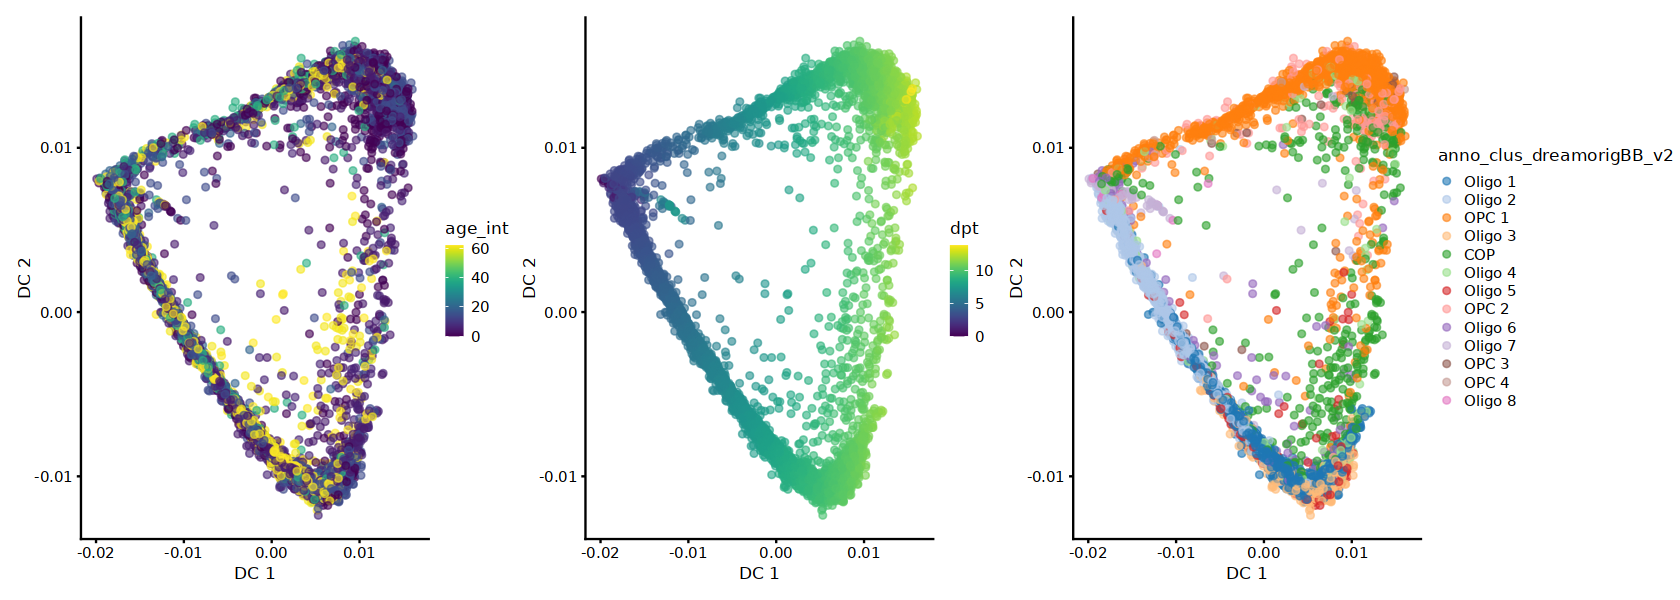

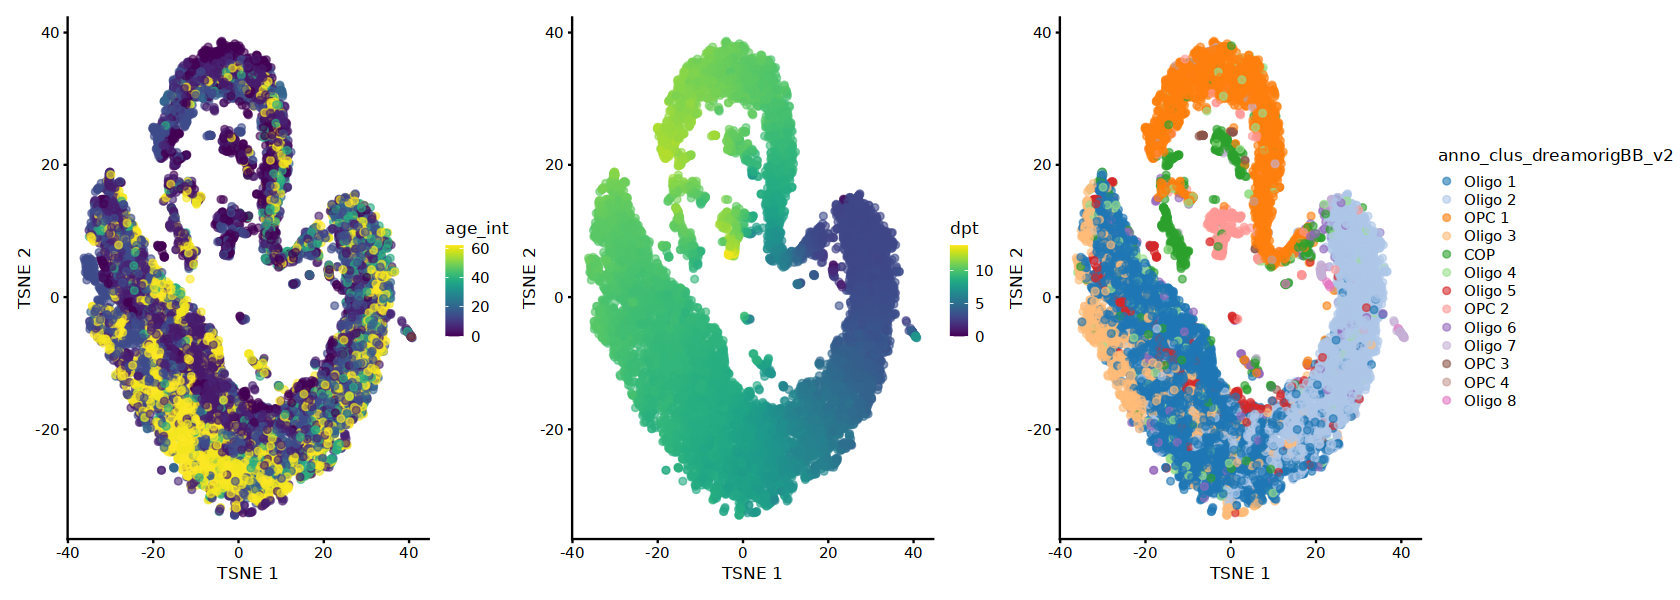

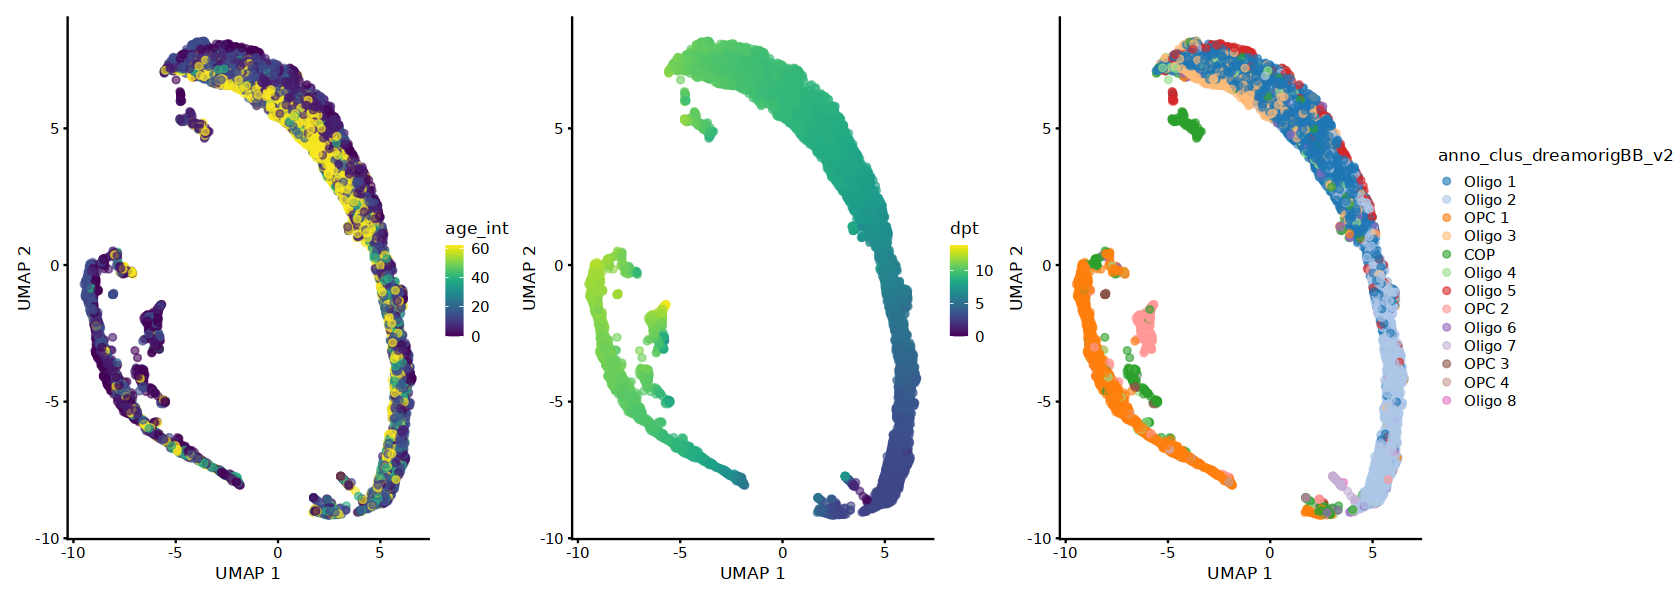

In [114]:
options(repr.plot.width=14, repr.plot.height=5)

p1 <- plotReducedDim(obj.sce, dimred="DC", colour_by="age_int")
p2 <- plotReducedDim(obj.sce, dimred="DC", colour_by="dpt")
p3 <-plotReducedDim(obj.sce, dimred="DC", colour_by="anno_clus_dreamorigBB_v2")
p1 + p2 + p3 + plot_layout(nrow=1)



set.seed(42)
obj.sce <- runTSNE(obj.sce, dimred='PCA')

p1 <- plotReducedDim(obj.sce, dimred="TSNE", colour_by="age_int")
p2 <- plotReducedDim(obj.sce, dimred="TSNE", colour_by="dpt")
p3 <-plotReducedDim(obj.sce, dimred="TSNE", colour_by="anno_clus_dreamorigBB_v2")
p1 + p2 + p3 + plot_layout(nrow=1)



set.seed(42)
obj.sce <- runUMAP(obj.sce, dimred='PCA')

p1 <- plotReducedDim(obj.sce, dimred="UMAP", colour_by="age_int")
p2 <- plotReducedDim(obj.sce, dimred="UMAP", colour_by="dpt")
p3 <-plotReducedDim(obj.sce, dimred="UMAP", colour_by="anno_clus_dreamorigBB_v2")
p1 + p2 + p3 + plot_layout(nrow=1)

In [105]:
require(tidyr)
gene <- c('SOX10', 'ID1', 'OLIG1', 'MYOG') #You can modify this list to whichever genes you want
expr_matrix <- as.data.frame(t(rbind(matrix[gene,, drop = FALSE],
                    dpt = obj.sce$dpt, age_int = as.character(obj.sce$age_int),
                                     Pseudotime = obj.sce$pseudotime_diffusionmap)))

df <- pivot_longer(expr_matrix, gene, names_to = 'feature', values_to = 'expr')

In [106]:
#Copy
df$expr <- as.numeric(as.character(df$expr)) #Some of the columns changed to characters after `pivot_longer` for some reason.
df$dpt <- as.numeric(as.character(df$dpt))
df$Pseudotime <- as.numeric(as.character(df$Pseudotime))
df$Time <- as.numeric(as.character(df$age_int)) #Generated a separate column for plotting purposes.

In [107]:
t <- obj.sce$dpt
var1K <- names(sort(apply(matrix, 1, var),decreasing = TRUE))[1:100] #We select the top variable genes to speed up the calculations. You are more than welcome to use all genes.
matrix <- matrix[var1K, ]

# fit a GAM using a spline
gam.pval <- apply(matrix,1,function(z){
    d <- data.frame(z=z, t=t)
    suppressWarnings({
      tmp <- suppressWarnings(gam(z ~ s(t), data=d))
    })
    p <- summary(tmp)[4][[1]][1,5]
    p
})

topgenes <- sort(gam.pval, decreasing = FALSE)[1:16] #selecting top 16 genes that are temporally expressed
topgenes <- topgenes[topgenes<0.05] %>% names() #filter for p < 0.05

expr_matrix <- as.data.frame(t(rbind(matrix[topgenes,, drop = FALSE],
                                     dpt = obj.sce$dpt, age_int = as.character(obj.sce$age_int))))

df <- pivot_longer(expr_matrix, topgenes, names_to = 'feature', values_to = 'expr')

Warning message:
"Transformation introduced infinite values in continuous y-axis"
Warning message:
"Transformation introduced infinite values in continuous y-axis"
`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'
Warning message:
"Removed 50903 rows containing non-finite values (`stat_smooth()`)."


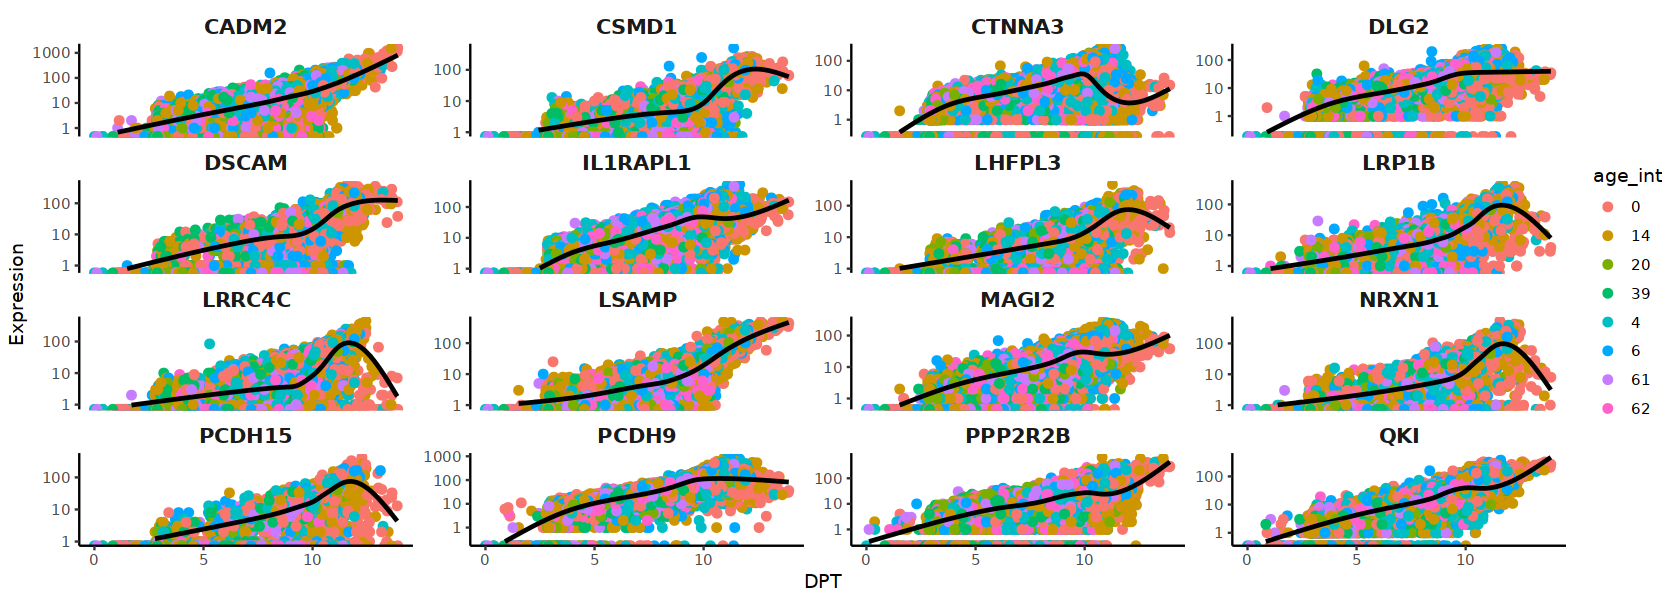

In [108]:
df$expr <- as.numeric(as.character(df$expr)) #Some of the columns changed to characters after `pivot_longer` for some reason.
df$dpt <- as.numeric(as.character(df$dpt))


p <- ggplot(df, mapping = aes(x=dpt, y=expr, color=age_int)) +
geom_jitter(size=2) + 
theme_classic() + 
xlab('DPT') +
ylab('Expression') + 
theme(plot.title = element_text(size=16, hjust =  0.5, face = 'bold'),
      strip.text = element_text(size=12, face = 'bold'),
      strip.background = element_rect(size = 0)) + 
guides(color = guide_legend(override.aes = list(linetype = 'blank'))) +
scale_y_log10() + facet_wrap(~feature,scales = "free_y")
p + geom_smooth(aes(color = expr), method = 'gam', se=F, color = 'black')